# Face Recognition #5

- We are using: DB1-Youtube (half database from A to I)
- We are performing new lighter embeddings for each person taking just random photograms
- We are then tuning tolerance and threshold parameter

In [1]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import numpy as np
import time

print(dlib.DLIB_USE_CUDA)
#dlib.DLIB_USE_CUDA = True

True


In [2]:
def createEncodingsLimited(dataset_folder, name, detection='cnn', enc_number = 20):
    dlib.DLIB_USE_CUDA = True

    # grab the paths to the input images in our dataset
    print("[INFO] creating encoding...")
    imagePaths = list(paths.list_images(dataset_folder))

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []
    
    total_pictures = len(imagePaths)
    random_values = np.random.randint(0, total_pictures, size=enc_number)

    # loop over the image paths
    for i in random_values:
        imagePath = imagePaths[i]
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        name = imagePath.split(os.path.sep)[-2]

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        image = cv2.imread(imagePath)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb,model=detection)

        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and
            # encodings
            knownEncodings.append(encoding)
            knownNames.append(name)

    # dump the facial encodings + names to disk
    print("[INFO] serializing encodings...")
    data = {"encodings": knownEncodings, "names": knownNames}
    name = "./encodings/" + name.split('/')[2] + '.pkl'
    print(name)
    f = open(name, "wb")
    f.write(pickle.dumps(data))
    f.close()

In [3]:
def faceRecognition(image, encodings, detection='cnn', show=False, tolerance = 0.6):
    start = time.time()
    # the image is already converted in an rgb format
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # format used by openCV
    data = encodings

    # detect the (x, y)-coordinates of the bounding boxes corresponding
    # to each face in the input image, then compute the facial embeddings
    # for each face
    boxes = face_recognition.face_locations(rgb,model=detection)
    encodings = face_recognition.face_encodings(rgb, boxes)

    # initialize the list of names for each face detected
    names = []

    # loop over the facial embeddings
    for encoding in encodings:
        # attempt to match each face in the input image to our known
        # encodings
        matches = face_recognition.compare_faces(data["encodings"], encoding, tolerance = tolerance)
        name = "unknown"

        # check to see if we have found a match
        if True in matches:
            # find the indexes of all matched faces then initialize a
            # dictionary to count the total number of times each face
            # was matched
            matchedIdxs = [i for (i, b) in enumerate(matches) if b]
            counts = {}

            # loop over the matched indexes and maintain a count for
            # each recognized face face
            for i in matchedIdxs:
                name = data["names"][i]
                counts[name] = counts.get(name, 0) + 1

            # determine the recognized face with the largest number of
            # votes (note: in the event of an unlikely tie Python will
            # select first entry in the dictionary)
            name = max(counts, key=counts.get)

        # update the list of names
        try:
            name = name.split('/')[2]
        except:
            name = name
        names.append(name)

    # loop over the recognized faces
    for ((top, right, bottom, left), name) in zip(boxes, names):
        # draw the predicted face name on the image
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
            0.75, (0, 255, 0), 2)
    
    
    stop = time.time()
    #print('Time needed:', stop-start, 'sec')
    # show the output image
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        print(names)
        plt.imshow(rgb)
        plt.show()
    return names

def imageRead(path, show=True):
    # BGR FORMAT #
    image = cv2.imread(path)
    
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        plt.imshow(rgb)
        plt.show()
    return image
    comp
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data

In [4]:
def faceRecOnFolder(dataset_folder, encodings, correct_person, detection='cnn', min_threshold = 0.85, 
                    max_threshold=0.10, tolerance = 0.6, stopping_perc = 50, show=False):
    imagePaths = list(paths.list_images(dataset_folder))

    analysed_frames = 0
    correct_frames = 0
    negative_frames = 0
    neutrum_frames = 0
    total_frames = len(imagePaths)
    start = time.time()
    
    min_frames = total_frames * stopping_perc / 100
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    print("[INFO] elements:", total_frames)

    # loop over the image paths
    for (i, imagePath) in enumerate(imagePaths):
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        image = imageRead(imagePath, show=False)
        person_rec = faceRecognition(image, encodings, detection='cnn', tolerance = tolerance, show=show)
        analysed_frames += 1
        
        if(len(person_rec) >= 1):
            person = person_rec[0]
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
            
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and correct_frames/analysed_frames < max_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return False, correct_rate, neutrum_rate, negative_rate
        
    #for ends
    correct_rate = correct_frames/total_frames
    neutrum_rate = neutrum_frames/total_frames
    negative_rate = negative_frames/total_frames
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate

#### Encodings generation
Let's build new lighter encodings for each persons. 

For this reasons we modify the existing function to take a random and limited number of pictures for reach person.
However we won't use it.

In [5]:
def createEncondingsonFolder(folder, min_v = 0, max_v = 10000, enc_number = 20):
    start = time.time()
    for person in valid_persons:
        count = count +1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        person = person[0:len(person)-1]
        test_folder = folder + person
        print(test_folder)
        # create the enconding related to first folder of the person
        folder_list = os.listdir(test_folder)
        first_n_folder = folder_list[0]
        train_folder = test_folder + "/" + first_n_folder
        res = os.path.exists("./encodings/" + person + ".pkl")
        if(res == False):
            createEncodings(train_folder, person, enc_number)
            
    end = time.time()
    print('Time needed', end-start)

In [6]:
#training_folder = '../#3/frame_images_DB/'
#createEncondingsonFolder(folder, min_v = 0, max_v = 1, enc_number = 20)

We can notice indeed that in the Aaron_Eckhart.plk training folder there are 85 pictures.
We mantain the same structure for the encoded files. So we can pick randomly a limited number of them from the already made ones.

In [7]:
def randomEncodingPicking(data, file_name, enc_number):
    new_enc = []
    new_names = []
    encodings = data['encodings']
    names = data['names']
    
    if( len(encodings) <= enc_number):
        new_enc = encodings
        new_names = names
    else:
        random_values = np.random.randint(0, len(encodings), size=enc_number)
        for r in random_values:
            new_enc.append(encodings[r])
            new_names.append(names[r])
            
    data = {"encodings": new_enc, "names": new_names}
    f = open('./encodings/' + file_name, "wb")
    f.write(pickle.dumps(data))
    f.close()
    return data

In [8]:
enc_folder = '../#3/encodings/'
name = 'Aaron_Eckhart.pkl'
data = encodingsRead(enc_folder + name)
print('Old number:', len(data['encodings']))
data = randomEncodingPicking(data, name, 20)
print('New number:', len(data['encodings']))

Old number: 85
New number: 20


In [9]:
def TrasformEncodings(source, enc_number):
    start = time.time()
    for file_name in os.listdir(source):
        print(file_name)
        data = encodingsRead(enc_folder + file_name)
        new_data = randomEncodingPicking(data, file_name, enc_number)

    end = time.time()
    print('Time needed', end-start)
    return

In [10]:
#TrasformEncodings(enc_folder, 20)

#### Tuning
Now we have light encodings. We can try to perform a faster training with multiple parameters. 

In [11]:
encodings_folder = "../#5/encodings/"
test_path = "../#3/frame_images_DB/"

In [12]:
### WE ARE DEFINING A FALSE THRESHOLD JUST TO MAKE THE TEST FASTER

def performTest(min_v=0, max_v=100000, true_threshold=0.85, false_threshold = 0.10, tolerance = 0.6, log=False):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    log_folder_base = 'test_tol' + '_' + str(tolerance) + '/'
    
    count = 0
    n_test = 0
    n_correct = 0
    filev = open("./valid.txt", "r")
    valid_persons = filev.readlines()
    filev.close()
    
    if( log == True):
        log_folder = log_folder_base + 'T/'
        try:
            os.mkdir("./" + log_folder_base)
            os.mkdir("./" + log_folder)
        except FileExistsError:
            print('Already existing folder')
        logfile = open("./" + log_folder + "log" + str(min_v) + "-" + str(max_v) + ".txt", "w")
                
    for person in valid_persons:
        count = count +1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        person = person[0:len(person)-1]
        test_folder = test_path + person
        #test_folder = test_folder.replace("/", "\\")
        print(test_folder)
        # create the enconding related to first folder of the person
        folder_list = os.listdir(test_folder)
        first_n_folder = folder_list[0]
        train_folder = test_folder + "/" + first_n_folder
        res = os.path.exists("./encodings/" + person + ".pkl")
        if(res == False):
            createEncodings(train_folder, person)
        
        # test the encodings of testset
        train_flag = 0
        for n_folder in folder_list:
            if( train_flag == 0):
                train_flag = 1
                continue
            
            n_test += 1
            folder = test_folder + "/" + n_folder
            encoding = encodingsRead("./encodings/" + person + ".pkl")
            v, a, b, c = faceRecOnFolder("./" + folder, encoding, person, min_threshold= true_threshold,
                                             max_threshold = false_threshold,  tolerance = tolerance, show=False)
            if(log== True):
                line = person + " " + n_folder + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)

            if( v == True):
                n_correct += 1
    
    if(log == True):
        logfile.close()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('Accuracy on videos tested:', n_correct/n_test)
    return

Crossed Test needs lots of hours to be completely performed. 
We are defining a subset of the dataset on which performing the testing tasks (150 people over the total of 445 belonging to my part). 
We are then performing the cross test on a 10% percentage in every testing folder.

In [13]:
testing_limit =  150

def performCrossedTest(min_v=0, max_v=1000, true_threshold=0.85, false_threshold= 0.10, tolerance = 0.6, log=False):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    log_folder_base = 'test_tol' + '_' + str(tolerance) + '/'

    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    filev = open("./valid.txt", "r")
    valid_persons = filev.readlines()
    filev.close()

    for encoding in enc_list:
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break
        n_test = 0
        n_correct = 0
        enc_name = encoding[0:len(encoding)-4]
        encoding_path = encodings_folder + encoding

        print('[ENC] Using encoding:', enc_name)

        
        if( log == True ):
            log_folder = log_folder_base + 'F/'
            try:
                #os.mkdir("./" + log_folder_base)
                os.mkdir("./" + log_folder)
            except FileExistsError:
                print('Already existing folder')
            logfile = open("./" + log_folder + "log_" + enc_name + ".txt", "w")

        p_count = 0
        for person in valid_persons:
            p_count += 1
            if( p_count > testing_limit):
                break
                
            person = person[0:len(person)-1]
            test_folder = test_path + person
            print('Cross testing on test folder:', person)
            folder_list = os.listdir(test_folder)

            person = person[0:len(person)]
            test_folder = test_path + person

            # test the encodings of testset
            train_flag = 0
            just_first = 0
            for n_folder in folder_list:
                if( enc_name == person ):
                    if( train_flag == 0):
                        train_flag = 1
                        just_first = 1
                        continue
                
                if( just_first == 1):
                    break
                    
                just_first +=1
                n_test += 1
                folder = test_folder + "/" + n_folder
                encoding = encodingsRead(encoding_path)
                #imagePaths = list(os.listdir(test_path + person + "/"))

                print(folder)
                v, a, b, c = faceRecOnFolder("./" + folder, encoding, person, min_threshold=true_threshold,
                                             max_threshold = false_threshold, tolerance = tolerance, 
                                             stopping_perc = 20, show=False)
                if(log== True):
                    line = person + " " + n_folder + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                    logfile.write(line)

                if( v == True):
                    n_correct += 1

        if(log == True):
            logfile.close()
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    return

#### Running test
We are defining a range of tolerances. We will analyse the thresholds after, thanks to the logs' file.

In [ ]:
performCrossedTest(min_v=1, max_v=5, true_threshold = 0.70, tolerance = 0.3, log=True)

In [14]:
#tol_values = [ 0.6, 0.5, 0.4, 0.3, 0.2, 0.1 ]
tol_values = [ 0.2, 0.1 ]

for tol in tol_values:
    print('**********************')
    print('TOLERANCE', tol)
    print('**********************')
    performTest(min_v=0, max_v=150, true_threshold = 0.70, tolerance = tol, log=True)
    performCrossedTest(min_v=0, max_v=5, true_threshold = 0.70, tolerance = tol, log=True)

**********************
TOLERANCE 0.4
**********************
-------------------------
TEST STARTED
-------------------------
../#3/frame_images_DB/Aaron_Eckhart
[INFO] Recognizing faces...
[INFO] elements: 49
Aaron_Eckhart Recognized after 25 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.012719631195068
../#3/frame_images_DB/Aaron_Tippin
[INFO] Recognizing faces...
[INFO] elements: 83
Aaron_Tippin Recognized after 42 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 12.762584209442139
../#3/frame_images_DB/Abba_Eban
[INFO] Recognizing faces...
[INFO] elements: 237
Abba_Eban Recognized after 119 with accuracy: 0.8487394957983193
Not detected: 0.15126050420168066 . Wrong recognition: 0.0
Time: 18.02544379234314
../#3/frame_images_DB/Abdel_Aziz_Al-Hakim
[INFO] Recognizing faces...
[INFO] elements: 285
Abdel_Aziz_Al-Hakim Recognized after 143 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 35.30605459213257
[INFO] Recognizing f

Alejandro_Gonzalez_Inarritu Recognized after 51 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 12.746973991394043
[INFO] Recognizing faces...
[INFO] elements: 61
Alejandro_Gonzalez_Inarritu Recognized after 31 with accuracy: 0.967741935483871
Not detected: 0.03225806451612903 . Wrong recognition: 0.0
Time: 8.73209834098816
../#3/frame_images_DB/Alejandro_Toledo
[INFO] Recognizing faces...
[INFO] elements: 154
Alejandro_Toledo Recognized after 101 with accuracy: 0.09900990099009901
Not detected: 0.900990099009901 . Wrong recognition: 0.0
Time: 15.043335199356079
[INFO] Recognizing faces...
[INFO] elements: 119
Alejandro_Toledo Recognized after 60 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 8.888521909713745
../#3/frame_images_DB/Aleksander_Kwasniewski
[INFO] Recognizing faces...
[INFO] elements: 175
Aleksander_Kwasniewski Recognized after 88 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 13.043785095214844
[INFO] Recogniz

Alison_Lohman Recognized after 38 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 16.870317697525024
../#3/frame_images_DB/Ali_Abbas
[INFO] Recognizing faces...
[INFO] elements: 65
Ali_Abbas Recognized after 33 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 14.647603511810303
[INFO] Recognizing faces...
[INFO] elements: 61
Ali_Abbas Recognized after 31 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.9306464195251465
[INFO] Recognizing faces...
[INFO] elements: 105
Ali_Abbas Recognized after 53 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.904390811920166
../#3/frame_images_DB/Ali_Fallahian
[INFO] Recognizing faces...
[INFO] elements: 81
Ali_Fallahian Recognized after 41 with accuracy: 0.9024390243902439
Not detected: 0.0975609756097561 . Wrong recognition: 0.0
Time: 5.462170362472534
../#3/frame_images_DB/Ali_Mohammed_Maher
[INFO] Recognizing faces...
[INFO] elements: 73
Ali_Mohammed_Maher Recognized

Andrea_Bocelli Recognized after 43 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 8.138696670532227
[INFO] Recognizing faces...
[INFO] elements: 53
Andrea_Bocelli Recognized after 27 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 12.116750001907349
../#3/frame_images_DB/Andrea_De_Cruz
[INFO] Recognizing faces...
[INFO] elements: 97
Andrea_De_Cruz Recognized after 49 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 9.914396286010742
../#3/frame_images_DB/Andres_Manuel_Lopez_Obrador
[INFO] Recognizing faces...
[INFO] elements: 53
Andres_Manuel_Lopez_Obrador Recognized after 27 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.7491087913513184
[INFO] Recognizing faces...
[INFO] elements: 185
Andres_Manuel_Lopez_Obrador Recognized after 93 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 13.788419485092163
../#3/frame_images_DB/Andrew_Bernard
[INFO] Recognizing faces...
[INFO] elements: 217


Barbara_Brezigar Recognized after 35 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 9.879727840423584
../#3/frame_images_DB/Barbara_Walters
[INFO] Recognizing faces...
[INFO] elements: 93
Barbara_Walters Recognized after 51 with accuracy: 0.09803921568627451
Not detected: 0.9019607843137255 . Wrong recognition: 0.0
Time: 9.229981899261475
[INFO] Recognizing faces...
[INFO] elements: 61
Barbara_Walters Recognized after 61 with accuracy: 0.5901639344262295
Not detected: 0.4098360655737705 . Wrong recognition: 0.0
Time: 12.470076322555542
[INFO] Recognizing faces...
[INFO] elements: 277
Barbara_Walters Recognized after 277 with accuracy: 0.3971119133574007
Not detected: 0.6028880866425993 . Wrong recognition: 0.0
Time: 50.92797303199768
../#3/frame_images_DB/Barbra_Streisand
[INFO] Recognizing faces...
[INFO] elements: 68
Barbra_Streisand Recognized after 35 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 17.66135835647583
[INFO] Recognizing faces.

Bernice_Wong Recognized after 25 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.214693546295166
../#3/frame_images_DB/Bertrand_Delanoe
[INFO] Recognizing faces...
[INFO] elements: 133
Bertrand_Delanoe Recognized after 133 with accuracy: 0.17293233082706766
Not detected: 0.8270676691729323 . Wrong recognition: 0.0
Time: 23.013973236083984
../#3/frame_images_DB/Betty_Williams
[INFO] Recognizing faces...
[INFO] elements: 189
Betty_Williams Recognized after 189 with accuracy: 0.10052910052910052
Not detected: 0.8994708994708994 . Wrong recognition: 0.0
Time: 30.252095222473145
../#3/frame_images_DB/Beyonce_Knowles
[INFO] Recognizing faces...
[INFO] elements: 57
Beyonce_Knowles Recognized after 29 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.597251653671265
[INFO] Recognizing faces...
[INFO] elements: 95
Beyonce_Knowles Recognized after 48 with accuracy: 0.0625
Not detected: 0.9375 . Wrong recognition: 0.0
Time: 10.465518712997437
../#3/frame_

Carlos_Iturgaitz Recognized after 214 with accuracy: 0.1308411214953271
Not detected: 0.8691588785046729 . Wrong recognition: 0.0
Time: 26.88700222969055
[INFO] Recognizing faces...
[INFO] elements: 750
Carlos_Iturgaitz Recognized after 376 with accuracy: 1.0
Not detected: 0.0 . Wrong recognition: 0.0
Time: 60.15610218048096
[INFO] Recognizing faces...
[INFO] elements: 304
Carlos_Iturgaitz Recognized after 153 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 24.108676433563232
../#3/frame_images_DB/Carlos_Menem
[INFO] Recognizing faces...
[INFO] elements: 75
Carlos_Menem Recognized after 38 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.2341837882995605
[INFO] Recognizing faces...
[INFO] elements: 71
Carlos_Menem Recognized after 36 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 16.66420602798462
../#3/frame_images_DB/Carlos_Queiroz
[INFO] Recognizing faces...
[INFO] elements: 77
Carlos_Queiroz Recognized after 39 with accu

Alanis_Morissette Recognized after 40 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.251033067703247
Cross testing on test folder: Alan_Ball
../#3/frame_images_DB/Alan_Ball/0
[INFO] Recognizing faces...
[INFO] elements: 56
Alan_Ball Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.5772056579589844
Cross testing on test folder: Alan_Dershowitz
../#3/frame_images_DB/Alan_Dershowitz/1
[INFO] Recognizing faces...
[INFO] elements: 119
Alan_Dershowitz Recognized after 24 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.8493916988372803
Cross testing on test folder: Alastair_Campbell
../#3/frame_images_DB/Alastair_Campbell/0
[INFO] Recognizing faces...
[INFO] elements: 78
Alastair_Campbell Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.3752501010894775
Cross testing on test folder: Alberto_Acosta
../#3/frame_images_DB/Alberto_Acosta/2
[INFO] Recognizing faces...
[IN

Ali_Fallahian Recognized after 44 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.06156611442566
Cross testing on test folder: Ali_Mohammed_Maher
../#3/frame_images_DB/Ali_Mohammed_Maher/1
[INFO] Recognizing faces...
[INFO] elements: 65
Ali_Mohammed_Maher Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.3222849369049072
Cross testing on test folder: Allyson_Felix
../#3/frame_images_DB/Allyson_Felix/0
[INFO] Recognizing faces...
[INFO] elements: 57
Allyson_Felix Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.4095306396484375
Cross testing on test folder: Ally_Sheedy
../#3/frame_images_DB/Ally_Sheedy/0
[INFO] Recognizing faces...
[INFO] elements: 73
Ally_Sheedy Recognized after 15 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.2312750816345215
Cross testing on test folder: Alma_Powell
../#3/frame_images_DB/Alma_Powell/0
[INFO] Recognizing faces...
[INFO] eleme

Angela_Lansbury Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.504920482635498
Cross testing on test folder: Angelina_Jolie
../#3/frame_images_DB/Angelina_Jolie/2
[INFO] Recognizing faces...
[INFO] elements: 79
Angelina_Jolie Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.483060359954834
Cross testing on test folder: Angelo_Reyes
../#3/frame_images_DB/Angelo_Reyes/0
[INFO] Recognizing faces...
[INFO] elements: 84
Angelo_Reyes Recognized after 17 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.7340526580810547
Cross testing on test folder: Angel_Lockward
../#3/frame_images_DB/Angel_Lockward/3
[INFO] Recognizing faces...
[INFO] elements: 1090
Angel_Lockward Recognized after 219 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 71.87965726852417
Cross testing on test folder: Anjum_Hussain
../#3/frame_images_DB/Anjum_Hussain/1
[INFO] Recognizing faces...
[INFO] elem

Bertrand_Delanoe Recognized after 36 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.111279726028442
Cross testing on test folder: Betty_Williams
../#3/frame_images_DB/Betty_Williams/0
[INFO] Recognizing faces...
[INFO] elements: 49
Betty_Williams Recognized after 10 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.1985414028167725
Cross testing on test folder: Beyonce_Knowles
../#3/frame_images_DB/Beyonce_Knowles/0
[INFO] Recognizing faces...
[INFO] elements: 65
Beyonce_Knowles Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.506744861602783
Cross testing on test folder: Bianca_Jagger
../#3/frame_images_DB/Bianca_Jagger/2
[INFO] Recognizing faces...
[INFO] elements: 81
Bianca_Jagger Recognized after 17 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.791295528411865
Cross testing on test folder: Biljana_Plavsic
../#3/frame_images_DB/Biljana_Plavsic/0
[INFO] Recognizing faces...
[I

Caroline_Dhavernas Recognized after 34 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.096356868743896
[ENC] Using encoding: Aaron_Tippin
Already existing folder
Cross testing on test folder: Aaron_Eckhart
../#3/frame_images_DB/Aaron_Eckhart/0
[INFO] Recognizing faces...
[INFO] elements: 85
Aaron_Eckhart Recognized after 18 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.232492446899414
Cross testing on test folder: Aaron_Tippin
Cross testing on test folder: Abba_Eban
../#3/frame_images_DB/Abba_Eban/0
[INFO] Recognizing faces...
[INFO] elements: 49
Abba_Eban Recognized after 10 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.836329221725464
Cross testing on test folder: Abdel_Aziz_Al-Hakim
../#3/frame_images_DB/Abdel_Aziz_Al-Hakim/0
[INFO] Recognizing faces...
[INFO] elements: 103
Abdel_Aziz_Al-Hakim Recognized after 21 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.026948690414429
Cross testing o

Alexander_Lukashenko Recognized after 26 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.279588937759399
Cross testing on test folder: Alexander_Payne
../#3/frame_images_DB/Alexander_Payne/2
[INFO] Recognizing faces...
[INFO] elements: 101
Alexander_Payne Recognized after 21 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.96015191078186
Cross testing on test folder: Alexandra_Pelosi
../#3/frame_images_DB/Alexandra_Pelosi/0
[INFO] Recognizing faces...
[INFO] elements: 166
Alexandra_Pelosi Recognized after 34 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.399747848510742
Cross testing on test folder: Alexandre_Despatie
../#3/frame_images_DB/Alexandre_Despatie/0
[INFO] Recognizing faces...
[INFO] elements: 139
Alexandre_Despatie Recognized after 28 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.550015211105347
Cross testing on test folder: Alexandre_Herchcovitch
../#3/frame_images_DB/Alexandre_Herch

Amber_Tamblyn Recognized after 27 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.410069704055786
Cross testing on test folder: Amelia_Vega
../#3/frame_images_DB/Amelia_Vega/1
[INFO] Recognizing faces...
[INFO] elements: 53
Amelia_Vega Recognized after 11 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.7796835899353027
Cross testing on test folder: Amr_Moussa
../#3/frame_images_DB/Amr_Moussa/2
[INFO] Recognizing faces...
[INFO] elements: 221
Amr_Moussa Recognized after 45 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 12.024909496307373
Cross testing on test folder: Amy_Brenneman
../#3/frame_images_DB/Amy_Brenneman/1
[INFO] Recognizing faces...
[INFO] elements: 77
Amy_Brenneman Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.110120058059692
Cross testing on test folder: Amy_Redford
../#3/frame_images_DB/Amy_Redford/0
[INFO] Recognizing faces...
[INFO] elements: 221
Amy_Redford Rec

Barry_Zito Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.4600067138671875
Cross testing on test folder: Bartosz_Kizierowski
../#3/frame_images_DB/Bartosz_Kizierowski/4
[INFO] Recognizing faces...
[INFO] elements: 134
Bartosz_Kizierowski Recognized after 27 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.290863752365112
Cross testing on test folder: Bashar_Assad
../#3/frame_images_DB/Bashar_Assad/1
[INFO] Recognizing faces...
[INFO] elements: 57
Bashar_Assad Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.3498542308807373
Cross testing on test folder: BB_King
../#3/frame_images_DB/BB_King/0
[INFO] Recognizing faces...
[INFO] elements: 101
BB_King Recognized after 21 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.5849356651306152
Cross testing on test folder: Beatriz_Merino
../#3/frame_images_DB/Beatriz_Merino/1
[INFO] Recognizing faces...
[INFO] elements: 23

Camryn_Manheim Recognized after 44 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.93409538269043
Cross testing on test folder: Carey_Lowell
../#3/frame_images_DB/Carey_Lowell/0
[INFO] Recognizing faces...
[INFO] elements: 187
Carey_Lowell Recognized after 38 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.938554286956787
Cross testing on test folder: Carla_Del_Ponte
../#3/frame_images_DB/Carla_Del_Ponte/1
[INFO] Recognizing faces...
[INFO] elements: 51
Carla_Del_Ponte Recognized after 11 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.7339670658111572
Cross testing on test folder: Carla_Gugino
../#3/frame_images_DB/Carla_Gugino/0
[INFO] Recognizing faces...
[INFO] elements: 68
Carla_Gugino Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.1885547637939453
Cross testing on test folder: Carla_Sullivan
../#3/frame_images_DB/Carla_Sullivan/2
[INFO] Recognizing faces...
[INFO] elements

AJ_Cook Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.972857236862183
Cross testing on test folder: Akbar_Al_Baker
../#3/frame_images_DB/Akbar_Al_Baker/2
[INFO] Recognizing faces...
[INFO] elements: 52
Akbar_Al_Baker Recognized after 11 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.7198231220245361
Cross testing on test folder: Akiko_Morigami
../#3/frame_images_DB/Akiko_Morigami/1
[INFO] Recognizing faces...
[INFO] elements: 51
Akiko_Morigami Recognized after 11 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.7339668273925781
Cross testing on test folder: Akmal_Taher
../#3/frame_images_DB/Akmal_Taher/2
[INFO] Recognizing faces...
[INFO] elements: 138
Akmal_Taher Recognized after 28 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.78171181678772
Cross testing on test folder: Alanis_Morissette
../#3/frame_images_DB/Alanis_Morissette/1
[INFO] Recognizing faces...
[INFO] elements:

Alicia_Silverstone Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.2025654315948486
Cross testing on test folder: Alicia_Witt
../#3/frame_images_DB/Alicia_Witt/4
[INFO] Recognizing faces...
[INFO] elements: 57
Alicia_Witt Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.7017920017242432
Cross testing on test folder: Alison_Lohman
../#3/frame_images_DB/Alison_Lohman/0
[INFO] Recognizing faces...
[INFO] elements: 466
Alison_Lohman Recognized after 94 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 23.93966770172119
Cross testing on test folder: Ali_Abbas
../#3/frame_images_DB/Ali_Abbas/2
[INFO] Recognizing faces...
[INFO] elements: 49
Ali_Abbas Recognized after 10 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.7183856964111328
Cross testing on test folder: Ali_Fallahian
../#3/frame_images_DB/Ali_Fallahian/0
[INFO] Recognizing faces...
[INFO] elements: 217
Ali_Fall

Andy_Lau Recognized after 26 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.4720635414123535
Cross testing on test folder: Andy_Roddick
../#3/frame_images_DB/Andy_Roddick/2
[INFO] Recognizing faces...
[INFO] elements: 53
Andy_Roddick Recognized after 11 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.0648117065429688
Cross testing on test folder: Andy_Rooney
../#3/frame_images_DB/Andy_Rooney/1
[INFO] Recognizing faces...
[INFO] elements: 92
Andy_Rooney Recognized after 19 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.37420916557312
Cross testing on test folder: Angela_Bassett
../#3/frame_images_DB/Angela_Bassett/2
[INFO] Recognizing faces...
[INFO] elements: 88
Angela_Bassett Recognized after 18 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.8342270851135254
Cross testing on test folder: Angela_Lansbury
../#3/frame_images_DB/Angela_Lansbury/0
[INFO] Recognizing faces...
[INFO] elements: 77
Angel

Ben_Stein Recognized after 50 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 9.040077686309814
Cross testing on test folder: Bernadette_Peters
../#3/frame_images_DB/Bernadette_Peters/0
[INFO] Recognizing faces...
[INFO] elements: 235
Bernadette_Peters Recognized after 48 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 13.470198392868042
Cross testing on test folder: Bernard_Landry
../#3/frame_images_DB/Bernard_Landry/2
[INFO] Recognizing faces...
[INFO] elements: 89
Bernard_Landry Recognized after 18 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.6098051071166992
Cross testing on test folder: Bernice_Wong
../#3/frame_images_DB/Bernice_Wong/1
[INFO] Recognizing faces...
[INFO] elements: 206
Bernice_Wong Recognized after 42 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.8135786056518555
Cross testing on test folder: Bertrand_Delanoe
../#3/frame_images_DB/Bertrand_Delanoe/0
[INFO] Recognizing faces...
[

Carlo_Azeglio_Ciampi Recognized after 10 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.620234727859497
Cross testing on test folder: Carly_Gullickson
../#3/frame_images_DB/Carly_Gullickson/1
[INFO] Recognizing faces...
[INFO] elements: 138
Carly_Gullickson Recognized after 28 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 12.730112314224243
Cross testing on test folder: Carl_Levin
../#3/frame_images_DB/Carl_Levin/1
[INFO] Recognizing faces...
[INFO] elements: 153
Carl_Levin Recognized after 31 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 6.979699373245239
Cross testing on test folder: Carolina_Kluft
../#3/frame_images_DB/Carolina_Kluft/0
[INFO] Recognizing faces...
[INFO] elements: 65
Carolina_Kluft Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.5296974182128906
Cross testing on test folder: Caroline_Dhavernas
../#3/frame_images_DB/Caroline_Dhavernas/0
[INFO] Recognizing faces

Alejandro_Toledo Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.054837226867676
Cross testing on test folder: Aleksander_Kwasniewski
../#3/frame_images_DB/Aleksander_Kwasniewski/0
[INFO] Recognizing faces...
[INFO] elements: 50
Aleksander_Kwasniewski Recognized after 11 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.749976396560669
Cross testing on test folder: Alek_Wek
../#3/frame_images_DB/Alek_Wek/0
[INFO] Recognizing faces...
[INFO] elements: 137
Alek_Wek Recognized after 28 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.9295144081115723
Cross testing on test folder: Alexander_Downer
../#3/frame_images_DB/Alexander_Downer/0
[INFO] Recognizing faces...
[INFO] elements: 97
Alexander_Downer Recognized after 20 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 6.05039644241333
Cross testing on test folder: Alexander_Lukashenko
../#3/frame_images_DB/Alexander_Lukashenko/1
[INFO] Re

Al_Pacino Recognized after 10 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.6099648475646973
Cross testing on test folder: Amanda_Beard
../#3/frame_images_DB/Amanda_Beard/0
[INFO] Recognizing faces...
[INFO] elements: 89
Amanda_Beard Recognized after 18 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 8.14016342163086
Cross testing on test folder: Amanda_Bynes
../#3/frame_images_DB/Amanda_Bynes/4
[INFO] Recognizing faces...
[INFO] elements: 49
Amanda_Bynes Recognized after 10 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.33174204826355
Cross testing on test folder: Amber_Frey
../#3/frame_images_DB/Amber_Frey/0
[INFO] Recognizing faces...
[INFO] elements: 100
Amber_Frey Recognized after 21 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.649965524673462
Cross testing on test folder: Amber_Tamblyn
../#3/frame_images_DB/Amber_Tamblyn/3
[INFO] Recognizing faces...
[INFO] elements: 133
Amber_Tamblyn Reco

Barry_Alvarez Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.2401390075683594
Cross testing on test folder: Barry_Diller
../#3/frame_images_DB/Barry_Diller/1
[INFO] Recognizing faces...
[INFO] elements: 169
Barry_Diller Recognized after 34 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 15.34000539779663
Cross testing on test folder: Barry_Switzer
../#3/frame_images_DB/Barry_Switzer/0
[INFO] Recognizing faces...
[INFO] elements: 141
Barry_Switzer Recognized after 29 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 8.159886598587036
Cross testing on test folder: Barry_Williams
../#3/frame_images_DB/Barry_Williams/1
[INFO] Recognizing faces...
[INFO] elements: 73
Barry_Williams Recognized after 15 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.6601343154907227
Cross testing on test folder: Barry_Zito
../#3/frame_images_DB/Barry_Zito/2
[INFO] Recognizing faces...
[INFO] elements: 65
Ba

Brian_Clemens Recognized after 68 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 18.28003215789795
Cross testing on test folder: Caio_Blat
../#3/frame_images_DB/Caio_Blat/1
[INFO] Recognizing faces...
[INFO] elements: 97
Caio_Blat Recognized after 20 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.0299153327941895
Cross testing on test folder: Calista_Flockhart
../#3/frame_images_DB/Calista_Flockhart/0
[INFO] Recognizing faces...
[INFO] elements: 60
Calista_Flockhart Recognized after 13 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.970014810562134
Cross testing on test folder: Cameron_Diaz
../#3/frame_images_DB/Cameron_Diaz/2
[INFO] Recognizing faces...
[INFO] elements: 66
Cameron_Diaz Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.000066041946411
Cross testing on test folder: Camryn_Manheim
../#3/frame_images_DB/Camryn_Manheim/0
[INFO] Recognizing faces...
[INFO] elements: 216

Agnes_Bruckner Recognized after 18 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.084728479385376
Cross testing on test folder: Ahmed_Ahmed
../#3/frame_images_DB/Ahmed_Ahmed/0
[INFO] Recognizing faces...
[INFO] elements: 197
Ahmed_Ahmed Recognized after 40 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.219560384750366
Cross testing on test folder: Aidan_Quinn
../#3/frame_images_DB/Aidan_Quinn/0
[INFO] Recognizing faces...
[INFO] elements: 76
Aidan_Quinn Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.39005184173584
Cross testing on test folder: Aishwarya_Rai
../#3/frame_images_DB/Aishwarya_Rai/0
[INFO] Recognizing faces...
[INFO] elements: 76
Aishwarya_Rai Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.5504536628723145
Cross testing on test folder: AJ_Cook
../#3/frame_images_DB/AJ_Cook/0
[INFO] Recognizing faces...
[INFO] elements: 79
AJ_Cook Recognized af

Alfonso_Cuaron Recognized after 131 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 36.76111674308777
Cross testing on test folder: Alfredo_di_Stefano
../#3/frame_images_DB/Alfredo_di_Stefano/0
[INFO] Recognizing faces...
[INFO] elements: 55
Alfredo_di_Stefano Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.944645643234253
Cross testing on test folder: Alfredo_Moreno
../#3/frame_images_DB/Alfredo_Moreno/0
[INFO] Recognizing faces...
[INFO] elements: 82
Alfredo_Moreno Recognized after 17 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.869946241378784
Cross testing on test folder: Alfred_Sant
../#3/frame_images_DB/Alfred_Sant/0
[INFO] Recognizing faces...
[INFO] elements: 59
Alfred_Sant Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.119866371154785
Cross testing on test folder: Alicia_Silverstone
../#3/frame_images_DB/Alicia_Silverstone/0
[INFO] Recognizing faces

Andrew_Cuomo Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.184905529022217
Cross testing on test folder: Andrew_Wetzler
../#3/frame_images_DB/Andrew_Wetzler/0
[INFO] Recognizing faces...
[INFO] elements: 221
Andrew_Wetzler Recognized after 45 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.170103073120117
Cross testing on test folder: Andre_Agassi
../#3/frame_images_DB/Andre_Agassi/4
[INFO] Recognizing faces...
[INFO] elements: 125
Andre_Agassi Recognized after 26 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.159854412078857
Cross testing on test folder: Andy_Dick
../#3/frame_images_DB/Andy_Dick/1
[INFO] Recognizing faces...
[INFO] elements: 53
Andy_Dick Recognized after 11 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.7603704929351807
Cross testing on test folder: Andy_Lau
../#3/frame_images_DB/Andy_Lau/1
[INFO] Recognizing faces...
[INFO] elements: 129
Andy_Lau Recognized

Ben_Broussard Recognized after 13 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.8198232650756836
Cross testing on test folder: Ben_Curtis
../#3/frame_images_DB/Ben_Curtis/0
[INFO] Recognizing faces...
[INFO] elements: 169
Ben_Curtis Recognized after 34 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 9.630419492721558
Cross testing on test folder: Ben_Kingsley
../#3/frame_images_DB/Ben_Kingsley/1
[INFO] Recognizing faces...
[INFO] elements: 77
Ben_Kingsley Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.7992660999298096
Cross testing on test folder: Ben_Lee
../#3/frame_images_DB/Ben_Lee/2
[INFO] Recognizing faces...
[INFO] elements: 67
Ben_Lee Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.277034044265747
Cross testing on test folder: Ben_Stein
../#3/frame_images_DB/Ben_Stein/1
[INFO] Recognizing faces...
[INFO] elements: 245
Ben_Stein Recognized after 50 with

Carlos_Queiroz Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.9002001285552979
Cross testing on test folder: Carlos_Quintanilla_Schmidt
../#3/frame_images_DB/Carlos_Quintanilla_Schmidt/1
[INFO] Recognizing faces...
[INFO] elements: 534
Carlos_Quintanilla_Schmidt Recognized after 107 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 30.13004732131958
Cross testing on test folder: Carlos_Salinas
../#3/frame_images_DB/Carlos_Salinas/0
[INFO] Recognizing faces...
[INFO] elements: 65
Carlos_Salinas Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.9498178958892822
Cross testing on test folder: Carlos_Vives
../#3/frame_images_DB/Carlos_Vives/0
[INFO] Recognizing faces...
[INFO] elements: 66
Carlos_Vives Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.529998302459717
Cross testing on test folder: Carlo_Azeglio_Ciampi
../#3/frame_images_DB/Carlo_Azeglio

Alan_Dershowitz Recognized after 29 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.029719114303589
../#3/frame_images_DB/Alastair_Campbell
[INFO] Recognizing faces...
[INFO] elements: 101
Alastair_Campbell Recognized after 51 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.49977993965149
[INFO] Recognizing faces...
[INFO] elements: 69
Alastair_Campbell Recognized after 35 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 8.129631757736206
../#3/frame_images_DB/Alberto_Acosta
[INFO] Recognizing faces...
[INFO] elements: 50
Alberto_Acosta Recognized after 26 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.010364294052124
../#3/frame_images_DB/Alberto_Gonzales
[INFO] Recognizing faces...
[INFO] elements: 340
Alberto_Gonzales Recognized after 171 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 27.555326461791992
[INFO] Recognizing faces...
[INFO] elements: 629
Alberto_Gonzales Recogniz

Alfredo_Moreno Recognized after 25 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.780153751373291
../#3/frame_images_DB/Alfred_Sant
[INFO] Recognizing faces...
[INFO] elements: 247
Alfred_Sant Recognized after 124 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 20.34981369972229
../#3/frame_images_DB/Alicia_Silverstone
[INFO] Recognizing faces...
[INFO] elements: 49
Alicia_Silverstone Recognized after 25 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.249843597412109
[INFO] Recognizing faces...
[INFO] elements: 73
Alicia_Silverstone Recognized after 37 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.9650726318359375
[INFO] Recognizing faces...
[INFO] elements: 78
Alicia_Silverstone Recognized after 40 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 6.47020697593689
../#3/frame_images_DB/Alicia_Witt
[INFO] Recognizing faces...
[INFO] elements: 75
Alicia_Witt Recognized after 38 wi

Amelia_Vega Recognized after 41 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 6.579724311828613
../#3/frame_images_DB/Amr_Moussa
[INFO] Recognizing faces...
[INFO] elements: 165
Amr_Moussa Recognized after 83 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 13.119749307632446
../#3/frame_images_DB/Amy_Brenneman
[INFO] Recognizing faces...
[INFO] elements: 49
Amy_Brenneman Recognized after 25 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.9699642658233643
[INFO] Recognizing faces...
[INFO] elements: 713
Amy_Brenneman Recognized after 357 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 162.02021670341492
[INFO] Recognizing faces...
[INFO] elements: 81
Amy_Brenneman Recognized after 41 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.620063066482544
../#3/frame_images_DB/Amy_Redford
[INFO] Recognizing faces...
[INFO] elements: 211
Amy_Redford Recognized after 106 with accuracy: 0.0
No

Barbara_Bodine Recognized after 246 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 39.13160037994385
../#3/frame_images_DB/Barbara_Boxer
[INFO] Recognizing faces...
[INFO] elements: 65
Barbara_Boxer Recognized after 65 with accuracy: 0.6307692307692307
Not detected: 0.36923076923076925 . Wrong recognition: 0.0
Time: 15.706761360168457
[INFO] Recognizing faces...
[INFO] elements: 86
Barbara_Boxer Recognized after 44 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 6.934947490692139
../#3/frame_images_DB/Barbara_Brezigar
[INFO] Recognizing faces...
[INFO] elements: 64
Barbara_Brezigar Recognized after 33 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 9.274089574813843
[INFO] Recognizing faces...
[INFO] elements: 761
Barbara_Brezigar Recognized after 761 with accuracy: 0.3219448094612352
Not detected: 0.6780551905387647 . Wrong recognition: 0.0
Time: 214.31579518318176
[INFO] Recognizing faces...
[INFO] elements: 91
Barbara_Brez

Bernadette_Peters Recognized after 63 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 9.076120615005493
[INFO] Recognizing faces...
[INFO] elements: 127
Bernadette_Peters Recognized after 64 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.093294620513916
../#3/frame_images_DB/Bernard_Landry
[INFO] Recognizing faces...
[INFO] elements: 113
Bernard_Landry Recognized after 57 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 9.007568359375
../#3/frame_images_DB/Bernice_Wong
[INFO] Recognizing faces...
[INFO] elements: 48
Bernice_Wong Recognized after 25 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.132707118988037
../#3/frame_images_DB/Bertrand_Delanoe
[INFO] Recognizing faces...
[INFO] elements: 133
Bertrand_Delanoe Recognized after 67 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.733954668045044
../#3/frame_images_DB/Betty_Williams
[INFO] Recognizing faces...
[INFO] elements: 18

Carlos_Ghosn Recognized after 32 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.389017343521118
../#3/frame_images_DB/Carlos_Iturgaitz
[INFO] Recognizing faces...
[INFO] elements: 214
Carlos_Iturgaitz Recognized after 108 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 12.661323308944702
[INFO] Recognizing faces...
[INFO] elements: 750
Carlos_Iturgaitz Recognized after 376 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 59.710753440856934
[INFO] Recognizing faces...
[INFO] elements: 304
Carlos_Iturgaitz Recognized after 153 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 23.939302921295166
../#3/frame_images_DB/Carlos_Menem
[INFO] Recognizing faces...
[INFO] elements: 75
Carlos_Menem Recognized after 38 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 7.230757236480713
[INFO] Recognizing faces...
[INFO] elements: 71
Carlos_Menem Recognized after 36 with accuracy: 0.0
Not detected: 1.0 

Alanis_Morissette Recognized after 40 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 11.128005504608154
Cross testing on test folder: Alan_Ball
../#3/frame_images_DB/Alan_Ball/0
[INFO] Recognizing faces...
[INFO] elements: 56
Alan_Ball Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.509617328643799
Cross testing on test folder: Alan_Dershowitz
../#3/frame_images_DB/Alan_Dershowitz/1
[INFO] Recognizing faces...
[INFO] elements: 119
Alan_Dershowitz Recognized after 24 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.7500641345977783
Cross testing on test folder: Alastair_Campbell
../#3/frame_images_DB/Alastair_Campbell/0
[INFO] Recognizing faces...
[INFO] elements: 78
Alastair_Campbell Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.269850015640259
Cross testing on test folder: Alberto_Acosta
../#3/frame_images_DB/Alberto_Acosta/2
[INFO] Recognizing faces...
[INFO

Ali_Fallahian Recognized after 44 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.386676788330078
Cross testing on test folder: Ali_Mohammed_Maher
../#3/frame_images_DB/Ali_Mohammed_Maher/1
[INFO] Recognizing faces...
[INFO] elements: 65
Ali_Mohammed_Maher Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.1915102005004883
Cross testing on test folder: Allyson_Felix
../#3/frame_images_DB/Allyson_Felix/0
[INFO] Recognizing faces...
[INFO] elements: 57
Allyson_Felix Recognized after 12 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 3.3440768718719482
Cross testing on test folder: Ally_Sheedy
../#3/frame_images_DB/Ally_Sheedy/0
[INFO] Recognizing faces...
[INFO] elements: 73
Ally_Sheedy Recognized after 15 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.171470642089844
Cross testing on test folder: Alma_Powell
../#3/frame_images_DB/Alma_Powell/0
[INFO] Recognizing faces...
[INFO] eleme

Angela_Lansbury Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.45467209815979
Cross testing on test folder: Angelina_Jolie
../#3/frame_images_DB/Angelina_Jolie/2
[INFO] Recognizing faces...
[INFO] elements: 79
Angelina_Jolie Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.4397337436676025
Cross testing on test folder: Angelo_Reyes
../#3/frame_images_DB/Angelo_Reyes/0
[INFO] Recognizing faces...
[INFO] elements: 84
Angelo_Reyes Recognized after 17 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.6804251670837402
Cross testing on test folder: Angel_Lockward
../#3/frame_images_DB/Angel_Lockward/3
[INFO] Recognizing faces...
[INFO] elements: 1090
Angel_Lockward Recognized after 219 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 69.96089720726013
Cross testing on test folder: Anjum_Hussain
../#3/frame_images_DB/Anjum_Hussain/1
[INFO] Recognizing faces...
[INFO] elem

Bertrand_Delanoe Recognized after 36 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.174224615097046
Cross testing on test folder: Betty_Williams
../#3/frame_images_DB/Betty_Williams/0
[INFO] Recognizing faces...
[INFO] elements: 49
Betty_Williams Recognized after 10 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.978057622909546
Cross testing on test folder: Beyonce_Knowles
../#3/frame_images_DB/Beyonce_Knowles/0
[INFO] Recognizing faces...
[INFO] elements: 65
Beyonce_Knowles Recognized after 14 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.4686176776885986
Cross testing on test folder: Bianca_Jagger
../#3/frame_images_DB/Bianca_Jagger/2
[INFO] Recognizing faces...
[INFO] elements: 81
Bianca_Jagger Recognized after 17 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.7265706062316895
Cross testing on test folder: Biljana_Plavsic
../#3/frame_images_DB/Biljana_Plavsic/0
[INFO] Recognizing faces...
[

Caroline_Dhavernas Recognized after 34 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.079118251800537
[ENC] Using encoding: Aaron_Tippin
Already existing folder
Cross testing on test folder: Aaron_Eckhart
../#3/frame_images_DB/Aaron_Eckhart/0
[INFO] Recognizing faces...
[INFO] elements: 85
Aaron_Eckhart Recognized after 18 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 5.128333568572998
Cross testing on test folder: Aaron_Tippin
Cross testing on test folder: Abba_Eban
../#3/frame_images_DB/Abba_Eban/0
[INFO] Recognizing faces...
[INFO] elements: 49
Abba_Eban Recognized after 10 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 2.7762327194213867
Cross testing on test folder: Abdel_Aziz_Al-Hakim
../#3/frame_images_DB/Abdel_Aziz_Al-Hakim/0
[INFO] Recognizing faces...
[INFO] elements: 103
Abdel_Aziz_Al-Hakim Recognized after 21 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.7091028690338135
Cross testing

Alexander_Lukashenko Recognized after 26 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.0581958293914795
Cross testing on test folder: Alexander_Payne
../#3/frame_images_DB/Alexander_Payne/2
[INFO] Recognizing faces...
[INFO] elements: 101
Alexander_Payne Recognized after 21 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.7342119216918945
Cross testing on test folder: Alexandra_Pelosi
../#3/frame_images_DB/Alexandra_Pelosi/0
[INFO] Recognizing faces...
[INFO] elements: 166
Alexandra_Pelosi Recognized after 34 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 10.878264665603638
Cross testing on test folder: Alexandre_Despatie
../#3/frame_images_DB/Alexandre_Despatie/0
[INFO] Recognizing faces...
[INFO] elements: 139
Alexandre_Despatie Recognized after 28 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.386032819747925
Cross testing on test folder: Alexandre_Herchcovitch
../#3/frame_images_DB/Alexandre_He

Amber_Tamblyn Recognized after 27 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.2501373291015625
Cross testing on test folder: Amelia_Vega
../#3/frame_images_DB/Amelia_Vega/1
[INFO] Recognizing faces...
[INFO] elements: 53
Amelia_Vega Recognized after 11 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 1.7303221225738525
Cross testing on test folder: Amr_Moussa
../#3/frame_images_DB/Amr_Moussa/2
[INFO] Recognizing faces...
[INFO] elements: 221
Amr_Moussa Recognized after 45 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 12.044811487197876
Cross testing on test folder: Amy_Brenneman
../#3/frame_images_DB/Amy_Brenneman/1
[INFO] Recognizing faces...
[INFO] elements: 77
Amy_Brenneman Recognized after 16 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 4.099982023239136
Cross testing on test folder: Amy_Redford
../#3/frame_images_DB/Amy_Redford/0
[INFO] Recognizing faces...
[INFO] elements: 221
Amy_Redford Re

KeyboardInterrupt: 

#### Statistics
Let's show a ROC curve for every

In [28]:
import os
import numpy as np

tol_values = [ 0.6, 0.5, 0.4, 0.3 ]
thr_values = [0.0, 0.45, 0.50, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
confirmed_rate = np.zeros(len(values))

def statsOnCrossedTest(tol):
    print('Tolerance:', tol)
    log_folder = "./test_tol_" + str(tol) + "/F/"
    files = os.listdir(log_folder)
    i = 0

    for thr in thr_values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        wrong_confirmed = 0
        wrong_confirmed2 = 0
        wrong_confirmed3 = 0
        wrong_confirmed4 = 0
        one_wrong_rec = 0
        persons = 0
        
        for f in files:
            if( f.startswith('log') == True):
                filev = open(log_folder + f, "r")
                vector = f.split('_')
                correct_person = vector[1] + "_" + vector[2]
                lines = filev.readlines()
                persons += 1
                for line in lines: 
                    #we don't want to make statistics on the same person
                    if(line.split(' ')[0] == correct_person):
                        continue

                    total_files += 1

                    rec_flag = line.split(' ')[2]
                    rec_percentage = float(line.split(' ')[3])
                    notdec_percentage = float(line.split(' ')[4])
                    notrec_percentage = float(line.split(' ')[5])

                    recognized = recognized + rec_percentage
                    notdetected = notdetected + notdec_percentage
                    wrong = wrong + notrec_percentage

                    if(notrec_percentage > thr):
                        wrong_confirmed = wrong_confirmed + 1

        confirmed_rate[i] = wrong_confirmed / total_files
        wrong_confirmed = 0
        i = i +1

    ## equal for each iteration
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files

    wrong_rec_on_persons = one_wrong_rec / (persons-1)
    return positive, undetected, negative, confirmed_rate

Tolerance: 0.6
Percentage of overall images that were correctly not recognized: 0.9574278131907088


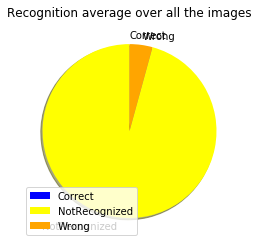

Tolerance: 0.5
Percentage of overall images that were correctly not recognized: 0.998066610120176


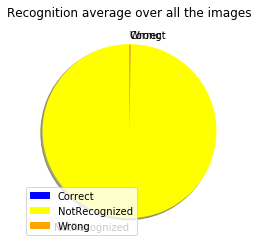

Tolerance: 0.4
Percentage of overall images that were correctly not recognized: 1.0


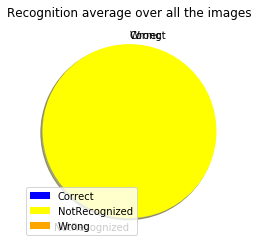

Tolerance: 0.3
Percentage of overall images that were correctly not recognized: 1.0


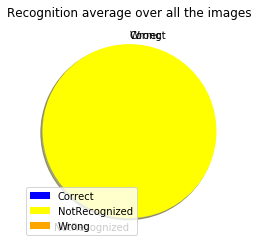

In [29]:
## WRONG ONES WHERE ASSIGNED TO THE PERSON EVEN HE WASN'T
tol_values = [ 0.6, 0.5, 0.4, 0.3 ]

for tol in tol_values:
    positive, undetected, negative, far = statsOnCrossedTest(tol)
    labels = ['Correct', 'NotRecognized', 'Wrong']
    colors = ['Blue', 'Yellow', 'Orange']
    sizes1 = [positive, undetected, negative]
    print('Percentage of overall images that were correctly not recognized:', undetected)

    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Recognition average over all the images')
    plt.legend()
    plt.show()

In [30]:
import numpy as np
import os


def statsOnTest(tol):
    print('Tolerance:', tol)
    TAR_path = "./test_tol_" + str(tol) + "/T/"
    files = os.listdir(TAR_path)
    confirmed_rateT = np.zeros(len(values))
    files = os.listdir(TAR_path)
    i = 0
    i=0

    for thr in values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        confirmed = 0
        total_files = 0

        for f in files:
            if( f.startswith('log') == True):
                filev = open(TAR_path + f, "r")
                lines = filev.readlines()
                for line in lines:
                    total_files += 1

                    rec_flag = line.split(' ')[2]
                    rec_percentage = float(line.split(' ')[3])
                    notdec_percentage = float(line.split(' ')[4])
                    notrec_percentage = float(line.split(' ')[5])

                    recognized = recognized + rec_percentage
                    notdetected = notdetected + notdec_percentage
                    wrong = wrong + notrec_percentage
                    if(rec_percentage > thr):
                        confirmed = confirmed + 1

        confirmed_rateT[i] = confirmed / total_files

        positive = recognized / total_files 
        undetected = notdetected / total_files
        negative = wrong / total_files

        i = i + 1
    
    return positive, undetected, negative, confirmed_rateT

ROC data are produced iterating on all the threshold values. The higher the threshold the lowest is the FAR, the lowest is the TAR.

We will produce several ROC curves, each one related to a specific tolerance.

Tolerance: 0.6
Tolerance: 0.6


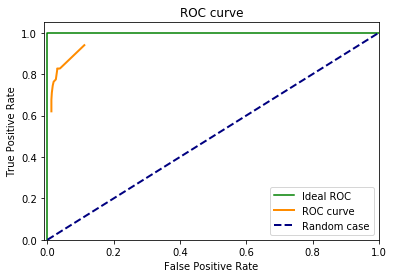

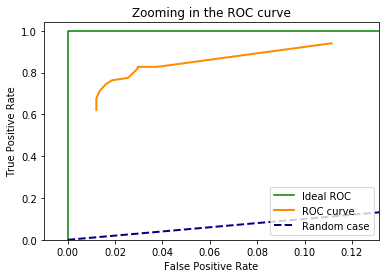

Tolerance: 0.5
Tolerance: 0.5


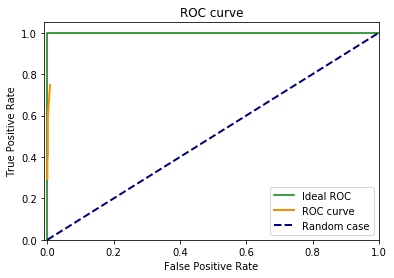

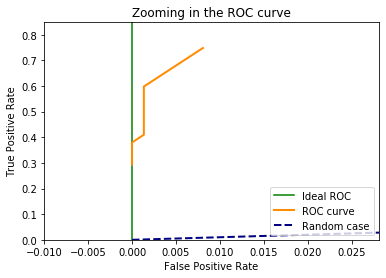

Tolerance: 0.4
Tolerance: 0.4


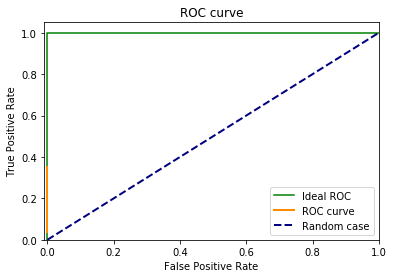

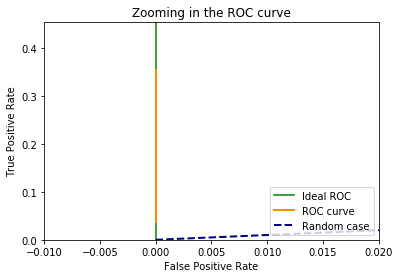

Tolerance: 0.3
Tolerance: 0.3


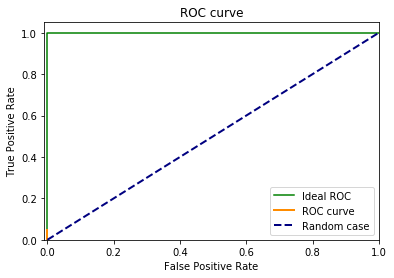

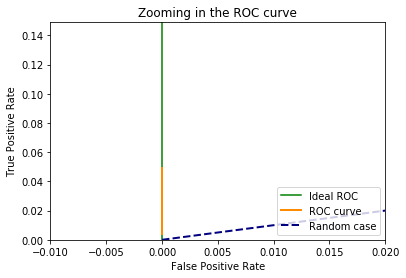

In [39]:
from sklearn.metrics import roc_curve, auc
for tol in tol_values:
    _, _, _, far = statsOnCrossedTest(tol)
    _, _, _, tar = statsOnTest(tol)
    fpr = far
    tpr = tar
    exampleX = [0.0, 0.00000001, 0.2, 0.8, 1.0]
    exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
    limitx = np.max(far)
    limity = np.max(tar)

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.01, limitx+0.02])
    plt.ylim([0.0, limity+0.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zooming in the ROC curve')
    plt.legend(loc="lower right")
    plt.show()

N.B. Data about tolerance = 0.3 are not still definitive.

As we can see, after 0.4 tolerance we have the perfect assurance that that we are confirming the right person (FAR = 0.0). At the same time also the TAR decreases to level that are not very pleasant for the users.